In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# Silnik ML
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
from sklearn.model_selection import cross_validate
import xgboost as xgb
from hyperopt import hp

In [4]:
data = pd.read_csv('training_sample.csv')

In [5]:
data.shape

(455401, 25)

In [6]:
data_to_join = pd.read_csv('testing_sample.csv')

In [7]:
data_to_join.shape

(151655, 25)

In [8]:
data = pd.concat([data, data_to_join], ignore_index=True)

In [9]:
data.shape

(607056, 25)

In [10]:
data.drop(columns=['UserID'], inplace = True)

In [11]:
data

,basket_icon_click,basket_add_list,basket_add_detail,sort_by,image_picker,account_page_click,promo_banner_click,detail_wishlist_add,list_size_dropdown,closed_minibasket_click,...,saw_sizecharts,saw_delivery,saw_account_upgrade,saw_homepage,device_mobile,device_computer,device_tablet,returning_user,loc_uk,ordered
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
4,0,1,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607051,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,1,0
607052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
607053,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0
607054,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,0


In [12]:
X = data.iloc[:,:-1]

In [13]:
y = data.iloc[:,-1]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [15]:
X_train.shape

(485644, 23)

In [16]:
X_test.shape

(121412, 23)

In [17]:
data_dm = xgb.DMatrix(data=X_train.values, label=y_train.values)

<AxesSubplot:>

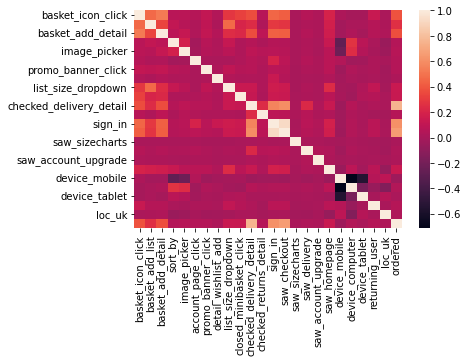

In [18]:
sns.heatmap(data.corr())

In [19]:
# Sprawdzanie niezbilansowania bazy
round((data[data == 1].count()/len(data))*100,2)

basket_icon_click           9.29
basket_add_list             7.11
basket_add_detail          10.61
sort_by                     3.67
image_picker                2.64
account_page_click          0.35
promo_banner_click          1.57
detail_wishlist_add         0.34
list_size_dropdown         22.68
closed_minibasket_click     1.63
checked_delivery_detail     5.30
checked_returns_detail      0.91
sign_in                     7.97
saw_checkout                7.07
saw_sizecharts              0.04
saw_delivery                0.54
saw_account_upgrade         0.11
saw_homepage               28.89
device_mobile              68.09
device_computer            19.58
device_tablet              12.63
returning_user             53.35
loc_uk                     93.20
ordered                     3.15
dtype: float64

In [20]:
positive_ordered = data[data['ordered']==1]

In [21]:
# Sprawdzanie niezbilansowania bazy
round((positive_ordered[positive_ordered == 0].count()/len(positive_ordered))*100,2)

basket_icon_click          28.89
basket_add_list            56.43
basket_add_detail          26.01
sort_by                    91.39
image_picker               91.81
account_page_click         98.01
promo_banner_click         94.97
detail_wishlist_add        98.98
list_size_dropdown         45.79
closed_minibasket_click    89.55
checked_delivery_detail     1.03
checked_returns_detail     96.37
sign_in                     0.61
saw_checkout                0.00
saw_sizecharts             99.89
saw_delivery               98.33
saw_account_upgrade        99.48
saw_homepage               36.77
device_mobile              41.49
device_computer            71.27
device_tablet              84.46
returning_user             32.13
loc_uk                      2.90
ordered                     0.00
dtype: float64

In [22]:
# Oblicznie stosunku 0 do 1 - argument do xgb classifier żeby zrównoważyć dane

neg_samples = np.sum(y == 0)
pos_samples = np.sum(y == 1)
scale_pos_weight = neg_samples / pos_samples

In [23]:
# Modele na początek
lr = LogisticRegression(class_weight='balanced')
dt = DecisionTreeClassifier(class_weight='balanced')
rf = RandomForestClassifier(n_estimators = 10, max_depth = 5, class_weight='balanced')
nb = GaussianNB() 
xgb_cl = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)

In [24]:
# Lista modeli
models = [lr, dt, rf, nb, xgb_cl]

In [25]:
# Metryki
scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']

Dla LogisticRegression: Accuracy: 0.992 | F1 Score: 0.939 | AUC Score: 0.997 | Precision: 0.897 | Recall: 0.992


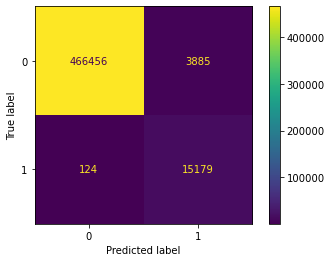

Dla DecisionTreeClassifier: Accuracy: 0.991 | F1 Score: 0.932 | AUC Score: 0.983 | Precision: 0.893 | Recall: 0.981


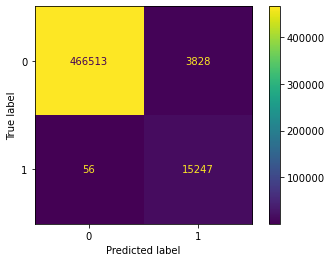

Dla RandomForestClassifier: Accuracy: 0.985 | F1 Score: 0.903 | AUC Score: 0.997 | Precision: 0.846 | Recall: 0.989


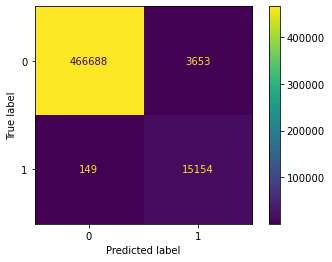

Dla GaussianNB: Accuracy: 0.988 | F1 Score: 0.916 | AUC Score: 0.995 | Precision: 0.863 | Recall: 0.988


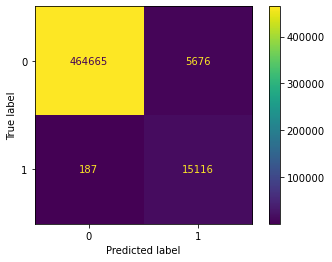

Dla XGBClassifier: Accuracy: 0.992 | F1 Score: 0.938 | AUC Score: 0.997 | Precision: 0.896 | Recall: 0.991


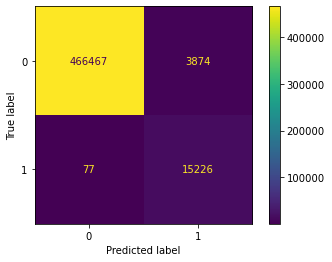

In [26]:
results = []

for model in models:
    # Trenowanie
    model.fit(X_train, y_train) 
    
    # Crossvalidation
    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=10)
    
    # Wyciąganie metryk
    accuracy = round(np.mean(scores['test_accuracy']),3)
    f1 = round(np.mean(scores['test_f1_macro']),3)
    AUC = round(np.mean(scores['test_roc_auc']),3)
    precision = round(np.mean(scores['test_precision_macro']),3)
    recall = round(np.mean(scores['test_recall_macro']),3)
    
    # Macierz pomyłek
    y_pred = model.predict(X_train)
    cm = confusion_matrix(y_train, y_pred)
    
    # Wyciąganie false_positives z confusion matrix (bo zauważyłam, że model sobie z nimi najgorzej radzi)
    fp = cm[0, 1]  
    
    # Metryki do listy pod df
    results.append({
        'model': model.__class__.__name__,
        'auc': AUC,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall, 
        'false_positives': fp})
    
    # Wydruk
    print('Dla {}: Accuracy: {} | F1 Score: {} | AUC Score: {} | Precision: {} | Recall: {}'.format(type(model).__name__, accuracy, f1, AUC, precision, recall))
    
    # Macierz pomyłek graficznie
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()  

In [27]:
# Porównanie metryk powyższych modeli w df
results_df = pd.DataFrame.from_records(results) 
results_df

,model,auc,accuracy,f1,precision,recall,false_positives
0,LogisticRegression,0.997,0.992,0.939,0.897,0.992,3885
1,DecisionTreeClassifier,0.983,0.991,0.932,0.893,0.981,3828
2,RandomForestClassifier,0.997,0.985,0.903,0.846,0.989,3653
3,GaussianNB,0.995,0.988,0.916,0.863,0.988,5676
4,XGBClassifier,0.997,0.992,0.938,0.896,0.991,3874


Krzywa ROC dla LogisticRegression


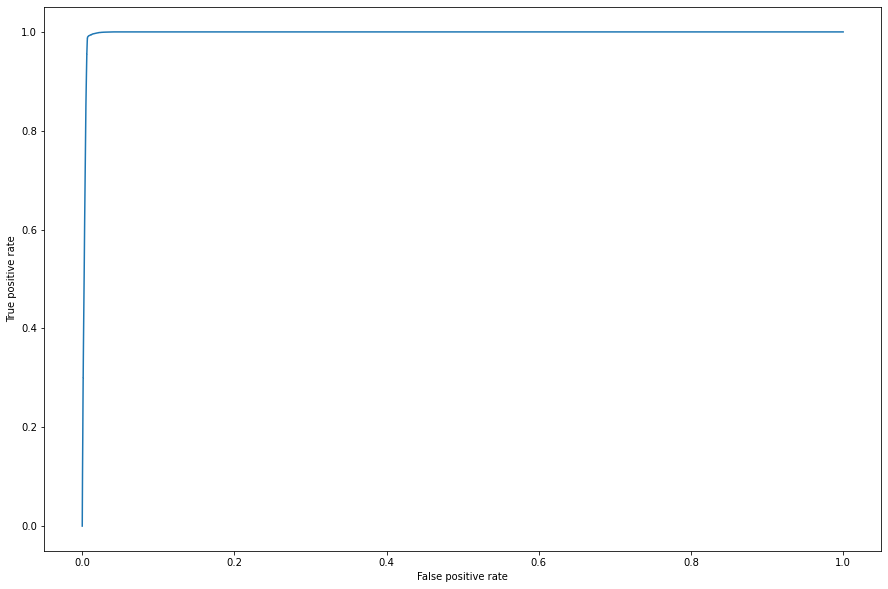

Krzywa ROC dla DecisionTreeClassifier


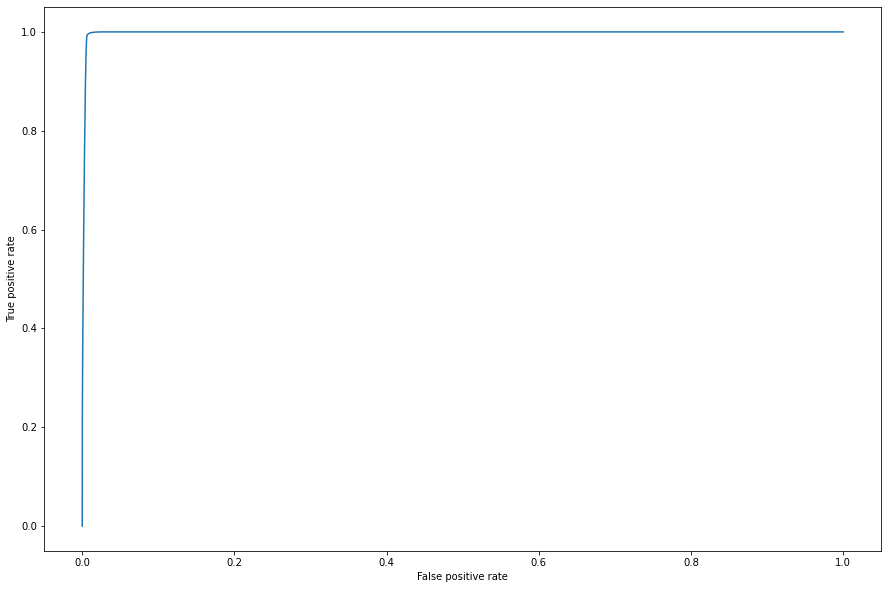

Krzywa ROC dla RandomForestClassifier


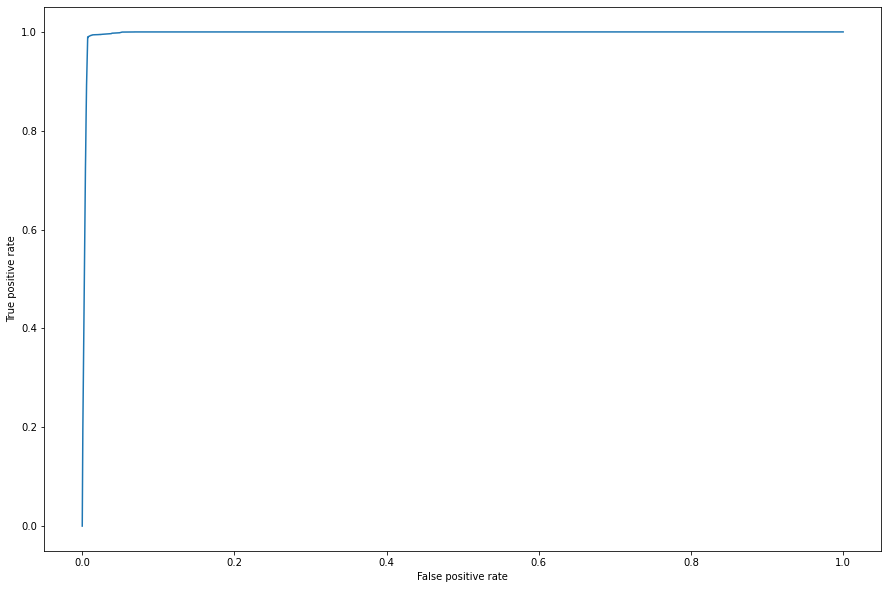

Krzywa ROC dla GaussianNB


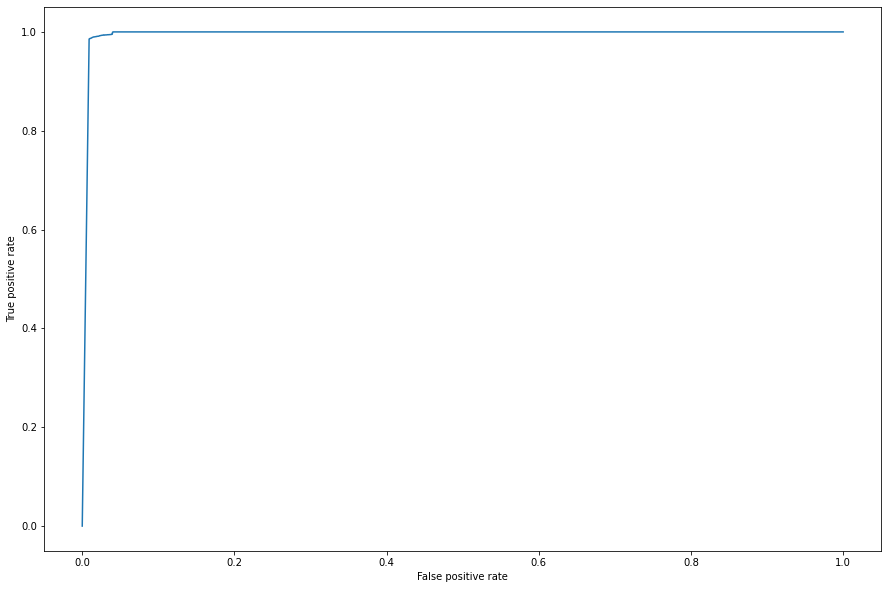

Krzywa ROC dla XGBClassifier


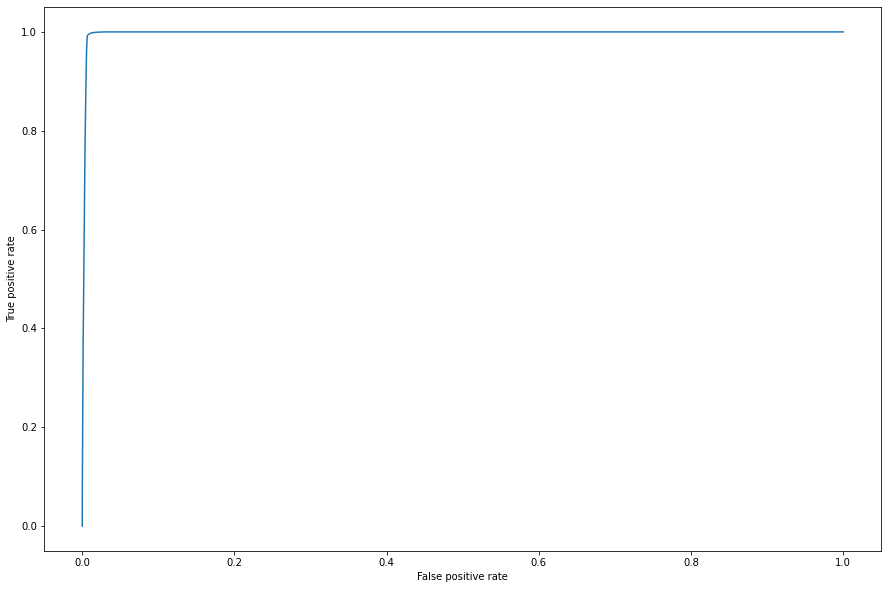

In [28]:
# Krzywe ROC (czy dobre dane czy powinny być testowe?)
for model in models:
    probas = model.predict_proba(X_train)
    positive_proba = probas[:, 1]
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, positive_proba)
    print('Krzywa ROC dla {}'.format(type(model).__name__))
    plt.figure(figsize=(15, 10))
    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.show()
 